In [703]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from turtle import speed

In [704]:
class MovementPhysics1D():
    
    def __init__(self, acc=0, vel=0, loc=0, bounce_cor=1) -> None:
        self.acc = acc # m/s2
        self.vel = vel # m/s
        self.loc = loc # m
        self.bounce_cor = bounce_cor # coefficient_of_restitution
        self.collision_counter = 0

    def update_vel(self, dt):
        self.vel =  self.acc * dt + self.vel

    def update_loc_without_collision(self, dt):
        self.update_vel(dt)
        self.loc = self.acc/2*np.power(dt,2) + self.vel * dt + self.loc # m
        return self.loc

    def update_loc(self, dt, boundary):
        prev_vel = self.vel
        prev_loc = self.loc
        self.update_vel(dt)
        self.loc = self.acc/2*np.power(dt,2) + self.vel * dt + self.loc # m

        if self.is_collision(boundary):
            #(self.loc - prev_loc)*dt + prev_loc = boundary.z # linear equasion
            dt_collision = ((boundary.z - prev_loc)/(self.loc - prev_loc))*dt
            self.vel = prev_vel # reset
            self.loc = prev_loc # reset
            self.update_vel(dt_collision)
            self.loc = boundary.z
            #self.loc = self.acc/2*np.power(dt_collision,2) + self.vel * dt_collision + self.loc # m

            self.vel = -self.vel*self.bounce_cor # bounce reverses speed
            self.update_vel(dt-dt_collision)
            self.loc = self.acc/2*np.power((dt-dt_collision),2) + self.vel * (dt-dt_collision) + self.loc # m

            if self.vel < 0: # ball has not enough energy cross border
                self.vel = 0
                self.loc = boundary.z
                
            self.collision_counter = self.collision_counter + 1

            return self.loc
            
        else:
            return self.loc


    def is_collision(self, boundary):
        return boundary.z > self.loc

In [705]:
class SimulationObject():

    def __init__(self, x_acc=0, x_vel=0, x_loc=0, y_acc=0, y_vel=0, y_loc=0, z_acc=-9.81, z_vel=0, z_loc=0, bounce_cor=1) -> None:
        self.x = MovementPhysics1D(x_acc, x_vel, x_loc, bounce_cor)
        self.y = MovementPhysics1D(y_acc, y_vel, y_loc, bounce_cor)
        self.z = MovementPhysics1D(z_acc, z_vel, z_loc, bounce_cor)

    # ToDo vector stuff
    

In [706]:
class Boundary():
    
    def __init__(self, z) -> None:
        self.z = z

In [707]:
fps = 100
dt = 1/fps
collisions = 3

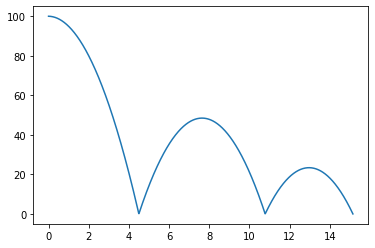

In [708]:
z_loc_history = np.empty((1,0))
x_loc_history = np.empty((1,0))
y_loc_history = np.empty((1,0))


ball = SimulationObject(z_loc=100, x_vel=10, x_acc= 1, y_vel=20, bounce_cor=0.7)
floor = Boundary(0)

while(ball.z.collision_counter<collisions):
        loc_now = ball.z.update_loc(dt, boundary=floor)
        z_loc_history = np.append(z_loc_history, loc_now)
        loc_now = ball.x.update_loc_without_collision(dt)
        x_loc_history = np.append(x_loc_history, loc_now)
        loc_now = ball.y.update_loc_without_collision(dt)
        y_loc_history = np.append(y_loc_history, loc_now)

td_acc_history = np.arange(0, len(z_loc_history))*dt

plt.plot(td_acc_history, z_loc_history)

In [709]:
#ToDo
# funnel
# vector format
# animate

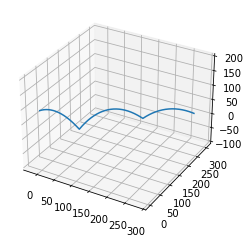

In [710]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scat = ax.plot3D(x_loc_history, y_loc_history ,z_loc_history)

# Create cubic bounding box to simulate equal aspect ratio, since matplotlib3d does not support aspect=equal
max_range = np.array([x_loc_history.max()-x_loc_history.min(), y_loc_history.max()-y_loc_history.min(), z_loc_history.max()-z_loc_history.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x_loc_history.max()+x_loc_history.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y_loc_history.max()+y_loc_history.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z_loc_history.max()+z_loc_history.min())

for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

plt.grid()
plt.show()

In [ ]:
#test git